### Simulate the dynamics of SRP54 and toxin SP interactions using ESMFlow

In [1]:
import os
import pandas as pd
import numpy as np
from glob import glob

def fasta_to_dataframe(seq):
    fasta_df = pd.read_csv(seq, sep='>', lineterminator='>', header=None)
    df = fasta_df[0].str.split('\n', n=1, expand=True)
    df[1] = df[1].replace('\n','', regex=True)
    df = df[df[1] != '']
    df = df.dropna()
    df.columns = ['tid','seq']
    return df

#### Get species for toxins obtained from https://www.uniprot.org/help/Toxins/statistics

In [2]:
tv = pd.read_csv('../data/uniprot/Animal_Toxin_Annotation_Project/uniprotkb_keyword_KW_0800_AND_reviewed_2024_11_13.tsv.gz', sep='\t')
tv = tv[tv['Signal peptide'].apply(lambda x: '000269' in str(x))]
tv['Species'] = tv.Organism.str.split('(').str[0].str.strip()
tv[['Species']].drop_duplicates().to_csv('../data/srp54/species.txt', header=None, index=None)

In [3]:
tv.head(1)

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Sequence,Organism,Signal peptide,OrthoDB,eggNOG,KEGG,Taxonomic lineage (Ids),Species
2,A0A0A1I6E7,reviewed,NDB4S_ANDCR,Antimicrobial peptide AcrAP1,NaN,MEIKYLLTVFLVLLIVSDHCQAFLFSLIPHAISGLISAFKGRRKRD...,Androctonus crassicauda (Arabian fat-tailed sc...,"SIGNAL 1..22; /evidence=""ECO:0000269|PubMed:25...",NaN,NaN,NaN,"131567 (no rank), 2759 (superkingdom), 33154 (...",Androctonus crassicauda


```
conda install -c conda-forge -c bioconda ncbi-datasets-cli hmmer -y

cat ../data/species.txt \
| while read i; do \
datasets summary genome taxon "$i"
done > ../data/datasets.species.txt
```

In [4]:
genome = pd.read_json('../data/srp54/datasets.species.txt', lines=True)
genome['genome'] = genome.reports.apply(lambda x: [i['accession'] for i in x])
genome['Species'] = genome.reports.apply(lambda x: list(set([i['organism']['organism_name'] for i in x]))[0])
genome = genome.explode('genome')
genome.genome.to_csv('../data/srp54/genomes.txt', header=None, index=None)

#### Download the proteomes for these species and do a homology search for SRP54 M-domains

```
cat ../data/srp54/genomes.txt | grep GCF_ \
| while read i; do \
    datasets download genome accession $i --include gff3,protein
    unzip -B ncbi_dataset.zip
    rm md5sum.txt README.md
    sleep 2
done

mv ncbi_dataset ../data/

wget https://ftp.ebi.ac.uk/pub/databases/Pfam/current_release/Pfam-A.hmm.gz
hmmfetch Pfam-A.hmm.gz PF02978.24 > ../data/srp54/PF02978.24.hmm
cat ../data/ncbi_dataset/data/*/protein.faa | hmmsearch --domtblout ../data/srp54/PF02978.24.domtblout ../data/srp54/PF02978.24.hmm -
```

#### Parse hmmsearch output and retrieve the full length SRP54 sequences for ESMFlow

In [5]:
from collections import defaultdict
from Bio import SearchIO

filename = '../data/srp54/PF02978.24.domtblout'

# https://biopython.org/docs/1.75/api/Bio.SearchIO.HmmerIO.html
hsp_attribs = ['hit_id','query_id','acc_avg','bias','bitscore','domain_index','env_start','env_end','evalue','evalue_cond','hit_start','hit_end','query_start','query_end']
# https://biofold.org/pages/courserevieweds/lb1-2/docs/6-HMMER.pdf
# !: pass both per-domain and per-sequence E-value thresholds (0.001). 
# ?: pass only one E-value threshold
# c-Evalue: conditional 
# E-value: statistical significance of the domain given that we know that the sequence is a true homolog 
# i-Evalue: independent E-value: statistical significance of the best domain identified in the sequence. Then the portions of the aligned HMM and the sequence are provided 
# Envelope is the best aligned sequence portion 
# Acc: mean per residue alignment a–posteriori probability

hsps = defaultdict(list)

hit_attribs = ['id','description','seq_len','bias','bitscore','evalue',]
hits = defaultdict(list)

with open(filename) as handle:
    for queryresult in SearchIO.parse(handle, 'hmmsearch3-domtab'):
        for hit in queryresult.hits:
            for hit_attrib in hit_attribs:
                hits[hit_attrib].append(getattr(hit, hit_attrib))
        for hsp in queryresult.hsps:
            for hsp_attrib in hsp_attribs:
                hsps[hsp_attrib].append(getattr(hsp, hsp_attrib))
                
hits_df = pd.DataFrame.from_dict(hits)
hsps_df = pd.DataFrame.from_dict(hsps)
hits_df.rename(columns={'id':'hit_id','bias':'overall_bias','bitscore':'overall_bitscore','evalue':'overall_evalue'}, inplace=True)
domtblout = pd.merge(hits_df[['hit_id','description']],hsps_df).drop_duplicates()
domtblout['env_start'] = domtblout.env_start.apply(lambda x: x-1 if x!=0 else x)
domtblout['query_start'] = domtblout.query_start.apply(lambda x: x-1 if x!=0 else x)
domtblout['coverage'] = (domtblout.env_end-domtblout.env_start)/ (np.max(domtblout.query_end.tolist())-np.min(domtblout.query_start.tolist()))
domtblout[domtblout.coverage>0.2].value_counts('query_id')

query_id
SRP_SPB    66
Name: count, dtype: int64

In [6]:
# XP_011174106.2 has is truncated
do = domtblout[domtblout.evalue<0.1]
do.columns

Index(['hit_id', 'description', 'query_id', 'acc_avg', 'bias', 'bitscore',
       'domain_index', 'env_start', 'env_end', 'evalue', 'evalue_cond',
       'hit_start', 'hit_end', 'query_start', 'query_end', 'coverage'],
      dtype='object')

#### Parse protein fasta files for toxin-producing species

In [7]:
fasta = []
for i in glob('../data/ncbi_dataset/data/*/protein.faa.gz'):
    fa = fasta_to_dataframe(i)
    fa['genome'] = os.path.split(i)[0].split('/')[-1]
    fasta.append(fa)

fasta = pd.concat(fasta)
fasta['hit_id'] = fasta.tid.str.split().str[0]
fas = pd.merge(fasta,do)[['genome','hit_id','seq']].drop_duplicates()

In [8]:
# multiple SRP54 copies
srpd = pd.merge(fas, fas[fas.duplicated('genome')][['genome']].drop_duplicates())
srpd = pd.merge(srpd, genome).drop(['reports','total_count'], axis=1)
tv = pd.merge(tv, srpd)
tv['seqres'] = tv.seq + ':' + tv.Sequence.str[:60]
tv['name'] = tv['hit_id'] + '_' + tv.Entry
tv[['name','seqres']].drop_duplicates().to_csv('../data/srp54/full_selected.csv', index=None)

* Select Centruroides sculpturatus (Arizona bark scorpion).
* Test the interactions between different SRP54 copies and toxin SPs. Use non-toxin SP-harbouring protein (signal peptide, CUB and EGF-like domain-containing protein 2) as a control

In [9]:
cs = tv[tv['hit_id'].str.contains('XP_023214277|XP_023222506')][['genome','hit_id','seq']].drop_duplicates()
csp = fasta[fasta['hit_id'].str.contains('XP_023240892.1')]

cs = pd.merge(cs,csp,on='genome')
cs['seqres'] = cs.seq_x + ':' + cs.seq_y.str[:60]
cs['name'] = cs['hit_id_x'] + '_' + cs['hit_id_y']
cs[['name','seqres']].drop_duplicates().to_csv('../data/srp54/selected.csv', index=None)

#### Plot contact map for an ESMFlow trajectory
SRP54 and Toxin CsEv1 from _Centruroides sculpturatus_ (Arizona bark scorpion)

In [1]:
import os
from glob import glob
import pandas as pd
import mdtraj as md
from contact_map import ContactFrequency
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
traj = md.load('../data/srp54/esmflow_out/XP_023222506.1_P01492.pdb.gz')
traj_contacts = ContactFrequency(traj)
traj_contacts = traj_contacts.residue_contacts.df

len_a = traj_contacts.shape[0]-60
traj_contacts.index = list(range(len_a)) + list(range(60))
traj_contacts.columns = list(range(len_a)) + list(range(60))

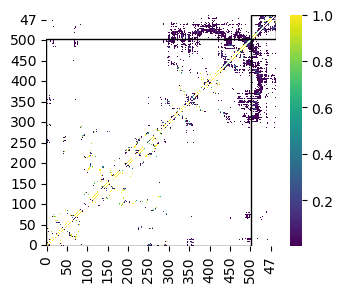

In [3]:
plt.figure(figsize=(3.7,3))
ax = sns.heatmap(traj_contacts, cmap='viridis', xticklabels = 50, yticklabels = 50)
ax.invert_yaxis()
ax.axvspan(xmin=0, xmax=len_a, ymax=len_a/traj_contacts.shape[0], edgecolor='k', facecolor='None')
ax.axvspan(xmin=len_a, xmax=traj_contacts.shape[0], ymin=len_a/traj_contacts.shape[0], edgecolor='k', facecolor='None')
plt.savefig('../data/srp54/contact_XP_023222506.1_P01492.pdf', bbox_inches='tight')

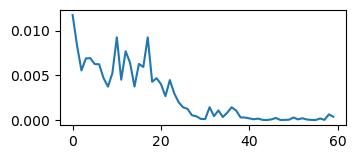

In [4]:
srp = traj_contacts.iloc[len_a:].T[:len_a].fillna(0)

plt.figure(figsize=(3.7,1.5))
plt.plot(srp.mean())

In [2]:
sp = []
srp = []

for i in glob('../data/srp54/esmflow_out/*.1_*.pdb.gz'):
    pair = os.path.split(i)[1].replace('.pdb','')
    traj = md.load(i)
    traj_contacts = ContactFrequency(traj)
    traj_contacts = traj_contacts.residue_contacts.df
    
    len_a = traj_contacts.shape[0]-60
    traj_contacts.index = list(range(len_a)) + list(range(60))
    traj_contacts.columns = list(range(len_a)) + list(range(60))
    inter = traj_contacts.iloc[len_a:].T[:len_a].fillna(0)
    sp.append([inter.mean().tolist(), pair])
    srp.append([inter.T.mean().tolist(), pair])

sp = pd.DataFrame(sp)
srp = pd.DataFrame(srp)
sp.to_pickle('../data/srp54/sp.pkl.gz')
srp.to_pickle('../data/srp54/srp.pkl.gz')

In [2]:
sp = pd.read_pickle('sp.pkl.gz')
srp = pd.read_pickle('srp.pkl.gz')
tsp = sp[~sp[1].str.contains('_XP')].reset_index(drop=True)
tsrp = srp[~srp[1].str.contains('_XP')].reset_index(drop=True)

nsp = sp[sp[1].str.contains('_XP')].reset_index(drop=True)
nsrp = srp[srp[1].str.contains('_XP')].reset_index(drop=True)

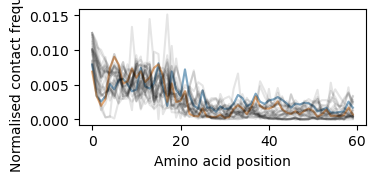

In [3]:
plt.figure(figsize=(3.7,1.5))

plt.plot(nsp[0].iloc[0], alpha=0.5)
plt.plot(nsp[0].iloc[1], alpha=0.5)

for i in range(tsp.shape[0]):
    plt.plot(sp[0][i], color='k', alpha=0.1)

plt.xlabel('Amino acid position')
plt.ylabel('Normalised contact frequency')
plt.savefig('../data/srp54/contact_sp.pdf', bbox_inches='tight')

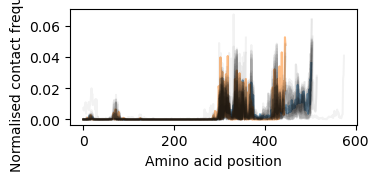

In [4]:
plt.figure(figsize=(3.7,1.5))
plt.plot(nsrp[0].iloc[0], alpha=0.5)
plt.plot(nsrp[0].iloc[1], alpha=0.5)

for i in range(tsrp.shape[0]):
    plt.plot(tsrp[0][i], color='k', alpha=0.05)
    

plt.xlabel('Amino acid position')
plt.ylabel('Normalised contact frequency')
plt.savefig('../data/srp54/contact_srp.pdf', bbox_inches='tight')